In [ ]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import nltk
import seaborn as sns
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import wordnet
from nltk import pos_tag
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve, GridSearchCV
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC #LinearSVC should scale better to a higher number of samples than SVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Embedding, SimpleRNN, LSTM, SpatialDropout1D, Flatten, Conv1D, MaxPooling1D, GlobalMaxPooling1D, GlobalAveragePooling1D, Bidirectional,GRU,Input, Dense, Activation, RepeatVector, Dropout, Concatenate

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            # logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            # print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print("Error: ",e)
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import Model

from transformers import BertTokenizer, TFBertModel
from transformers import RobertaTokenizer, TFRobertaModel
from transformers import XLNetTokenizer, TFXLNetModel

from scipy.stats import pearsonr

from langdetect import detect
import langid

pd.set_option('display.max_colwidth', 50)

In [2]:
def check(df):
    l=[]
    columns=df.columns
    for col in columns:
        dtypes=df[col].dtypes
        nunique=df[col].nunique()
        sum_null=df[col].isnull().sum()
        l.append([col,dtypes,nunique,sum_null])
    df_check=pd.DataFrame(l)
    df_check.columns=['column','dtypes','nunique','sum_null']
    return df_check 

In [35]:
df = pd.read_csv("Final_Dataset_portuguese.csv")

In [36]:
check(df)

column  dtypes  nunique  sum_null
0    Text  object    52283         0
1  Source  object     3101     13003
2     URL  object    63235         0
3   Label   int64        2         0

In [37]:
df.head()

Text           Source  \
0  PJ em operação internacional de tráfico de dro...               DN   
1  O texto foi criado - numa universidade da Repú...              NaN   
2  Nunca pague multas por conduzir sem carta ou s...  Contas Poupança   
3  Depois de António Guterres, uma estátua de D. ...    redes sociais   
4  O MAR, uma droga gratuita que cura pelo menos ...           Coruja   

                                                 URL  Label  
0  https://www.dn.pt/sociedade/pj-em-operacao-int...      1  
1  https://poligrafo.sapo.pt/fact-check/fact-chec...      1  
2  https://arquivo.pt/wayback/20200626170105mp_/h...      0  
3  https://poligrafo.sapo.pt/fact-check/fact-chec...      0  
4  https://arquivo.pt/wayback/20181012145922mp_/h...      0

In [38]:
def remove_stopwords(text):
    stop_words = set(stopwords.words('portuguese'))
    words = word_tokenize(text)
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return " ".join(filtered_words)

df['Text'] = df['Text'].apply(remove_stopwords)

In [39]:
#df['Text'] = df['Text'].apply(lambda x: re.sub('[^a-zA-Z0-9\s]', '', x))
df['Text'] = df['Text'].apply(lambda x: re.sub(r'[^\w\s]', '', x))
df['Text'] = df['Text'].apply(lambda x: x.lower())

Text(0.5, 1.0, '15 Most Common Words in Fake News')

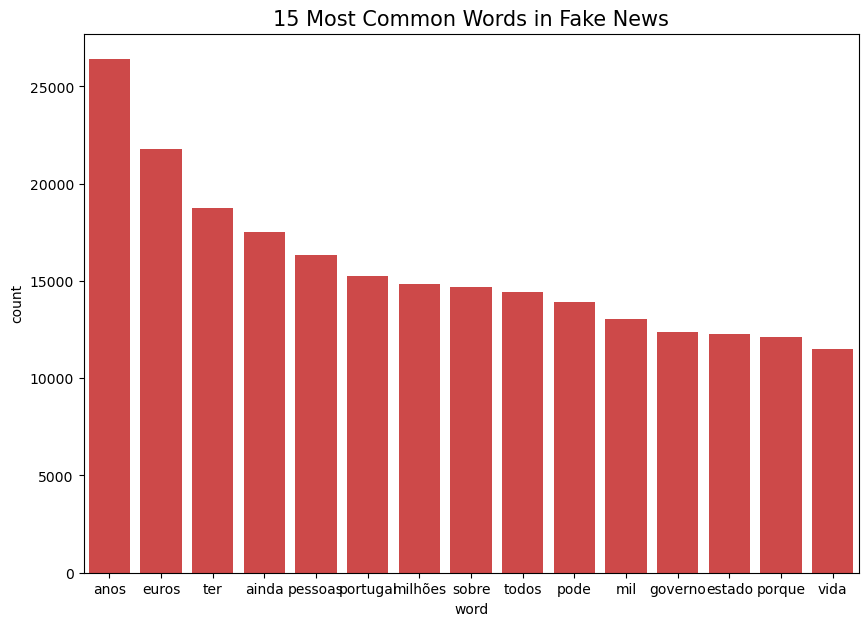

In [40]:
import collections

#get word collections for real/fake news
fake_news_words = collections.Counter([word for sentence in df.loc[df['Label'] == 0]['Text'] for word in sentence.split()])

df_mc_fake = pd.DataFrame(columns = ['word','count'], data=(fake_news_words.most_common(15)))

fig, axes = plt.subplots(1,1,figsize = (10, 7))

sns.barplot(data = df_mc_fake, x= 'word', y = 'count', color = '#dd0000', alpha = 0.8, ax = axes)
axes.set_title('15 Most Common Words in Fake News',  fontsize=15)


Text(0.5, 1.0, '15 Most Common Words in Real News')

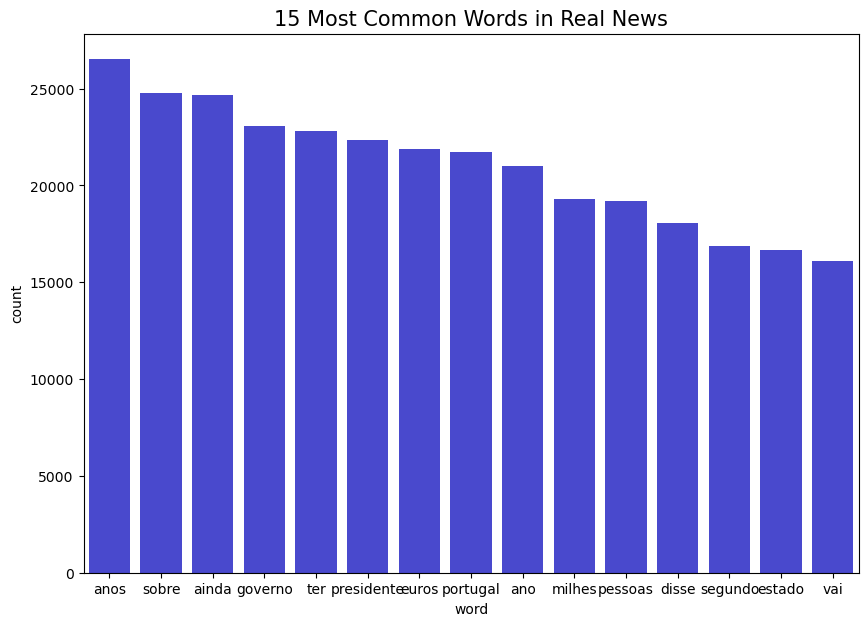

In [29]:
real_news_words = collections.Counter([word for sentence in df.loc[df['Label'] == 1]['Text'] for word in sentence.split()])

df_mc_real = pd.DataFrame(columns = ['word','count'], data=(real_news_words.most_common(15)))

fig, axes = plt.subplots(1,1,figsize = (10, 7))

sns.barplot(data = df_mc_real, x= 'word', y = 'count', color = '#0000dd', alpha = 0.8, ax = axes)
axes.set_title('15 Most Common Words in Real News',  fontsize=15)

500 most common words in the Portuguese dataset


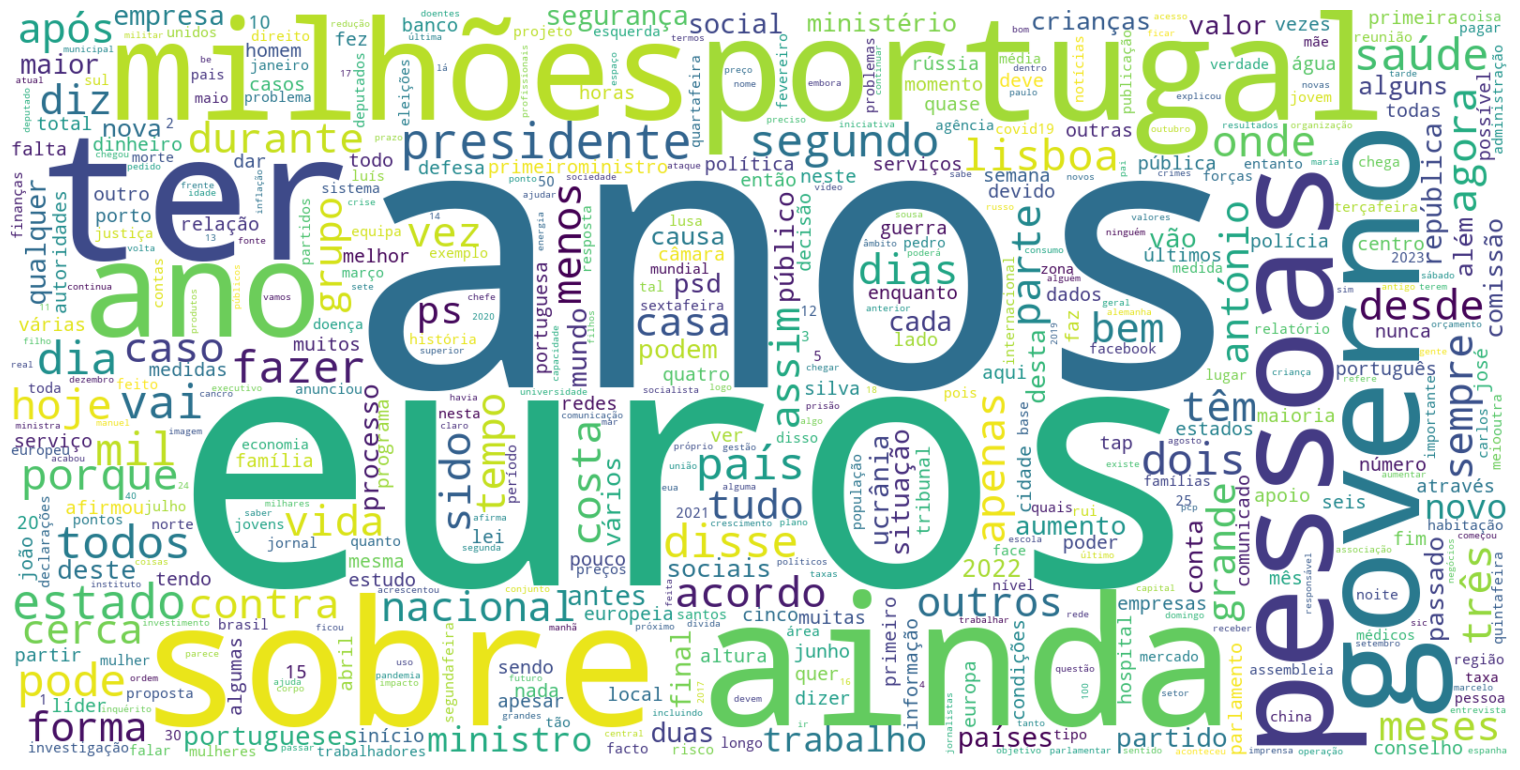

In [41]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Sample dataset (replace with your actual data)
all_text = ' '.join(df['Text'])

# Calculate word frequencies
word_frequencies = collections.Counter(all_text.split())

# Generate the word cloud using the most common words
wordcloud = WordCloud(width=1600, height=800, background_color='white', max_words=500).generate_from_frequencies(word_frequencies)

# Plot the word cloud
print("500 most common words in the Portuguese dataset")
plt.figure(figsize=(15, 9))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off axis numbers and labels
plt.tight_layout(pad=0)
plt.show()

500 most common words in Portuguese fake news


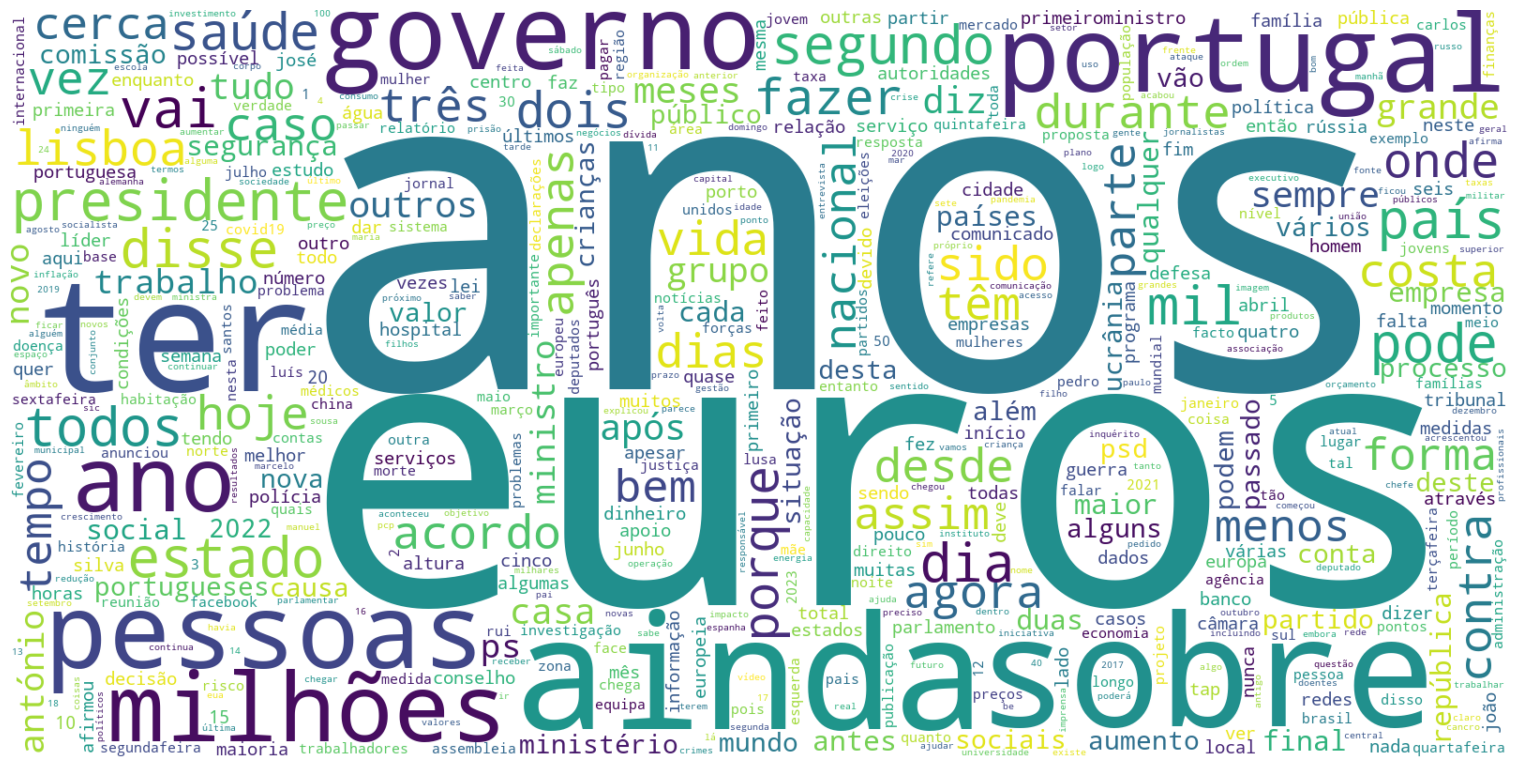

In [42]:
# Sample dataset (replace with your actual data)
fake_text = ' '.join(df.loc[df['Label'] == 0]['Text'])  # Concatenate fake texts

# Calculate word frequencies for fake texts
fake_word_frequencies = collections.Counter(fake_text.split())

# Generate the word cloud using the most common words
wordcloud = WordCloud(width=1600, height=800, background_color='white', max_words=500).generate_from_frequencies(word_frequencies)

# Plot the word cloud
print("500 most common words in Portuguese fake news")
plt.figure(figsize=(15, 9))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off axis numbers and labels
plt.tight_layout(pad=0)
plt.show()

500 most common words in Portuguese real news


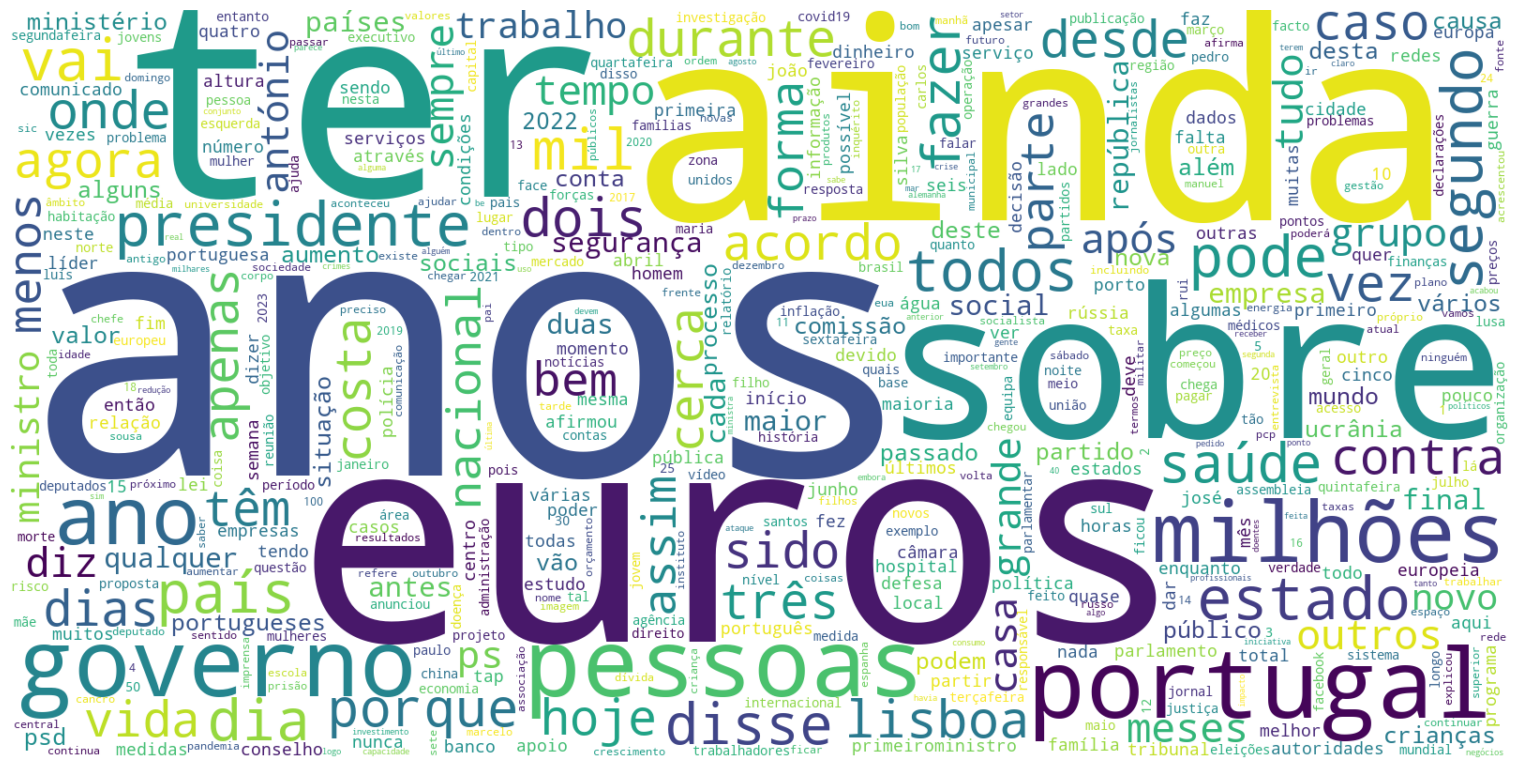

In [43]:
# Sample dataset (replace with your actual data)
fake_text = ' '.join(df.loc[df['Label'] == 1]['Text'])  # Concatenate fake texts

# Calculate word frequencies for fake texts
fake_word_frequencies = collections.Counter(fake_text.split())

# Generate the word cloud using the most common words
wordcloud = WordCloud(width=1600, height=800, background_color='white', max_words=500).generate_from_frequencies(word_frequencies)

# Plot the word cloud
print("500 most common words in Portuguese real news")
plt.figure(figsize=(15, 9))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off axis numbers and labels
plt.tight_layout(pad=0)
plt.show()

300 most common bi-grams in Portuguese fake news


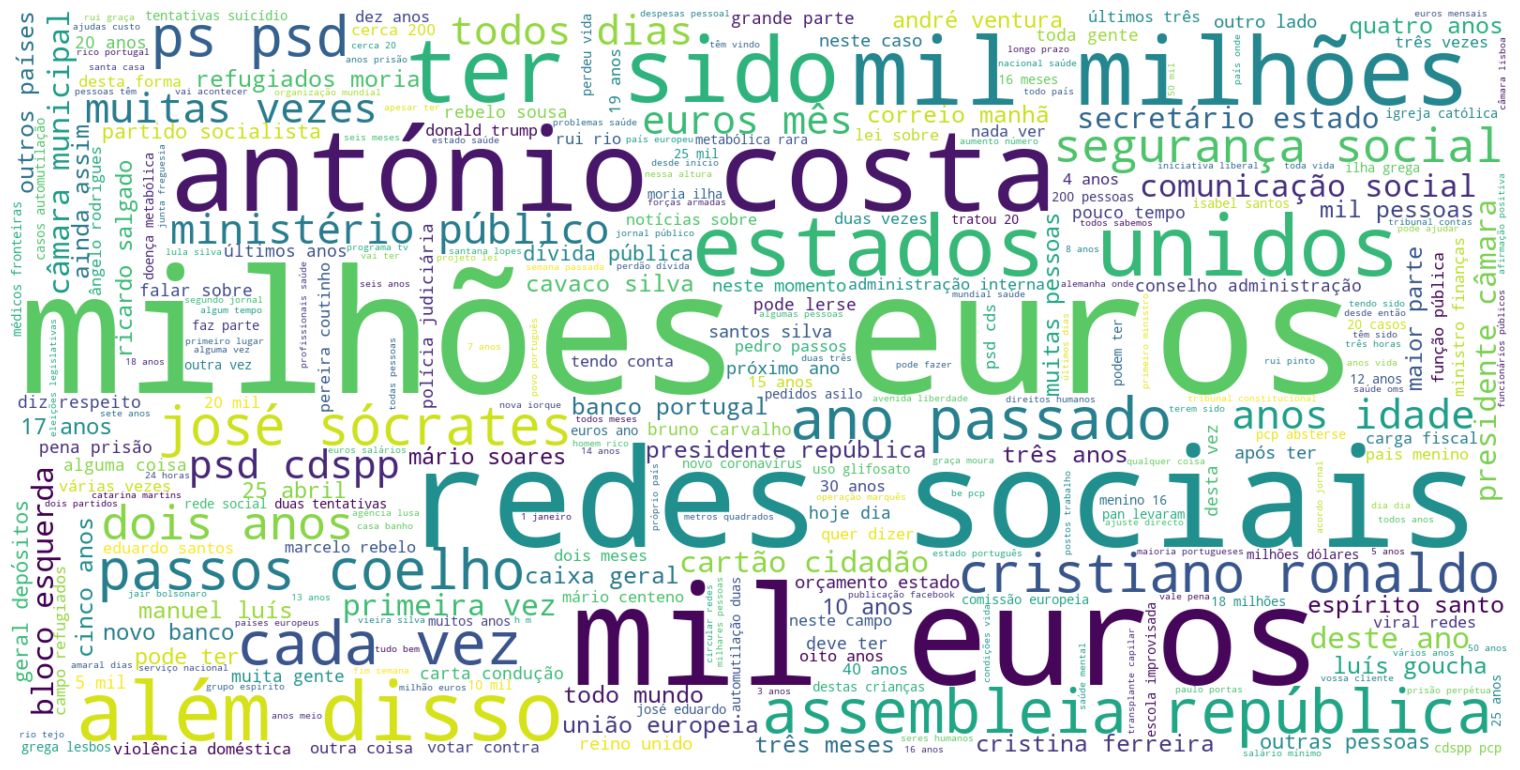

In [47]:
from nltk.util import ngrams

# Sample dataset (replace with your actual data)
fake_text = ' '.join(df.loc[df['Label'] == 0]['Text'])  # Concatenate fake texts

# Tokenize the text into words
words = nltk.word_tokenize(fake_text)

# Create bi-grams from the words
bi_grams = list(ngrams(words, 2))  # Change '2' to the desired n-gram size

# Convert bi-grams back to strings
bi_gram_strings = [' '.join(gram) for gram in bi_grams]

# Calculate bi-gram frequencies
bi_gram_frequencies = collections.Counter(bi_gram_strings)

# Generate the word cloud using the most common bi-grams
wordcloud = WordCloud(width=1600, height=800, background_color='white', max_words=300).generate_from_frequencies(bi_gram_frequencies)

# Plot the word cloud
print("300 most common bi-grams in Portuguese fake news")
plt.figure(figsize=(15, 9))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off axis numbers and labels
plt.tight_layout(pad=0)
plt.show()

300 most common bi-grams in Portuguese real news


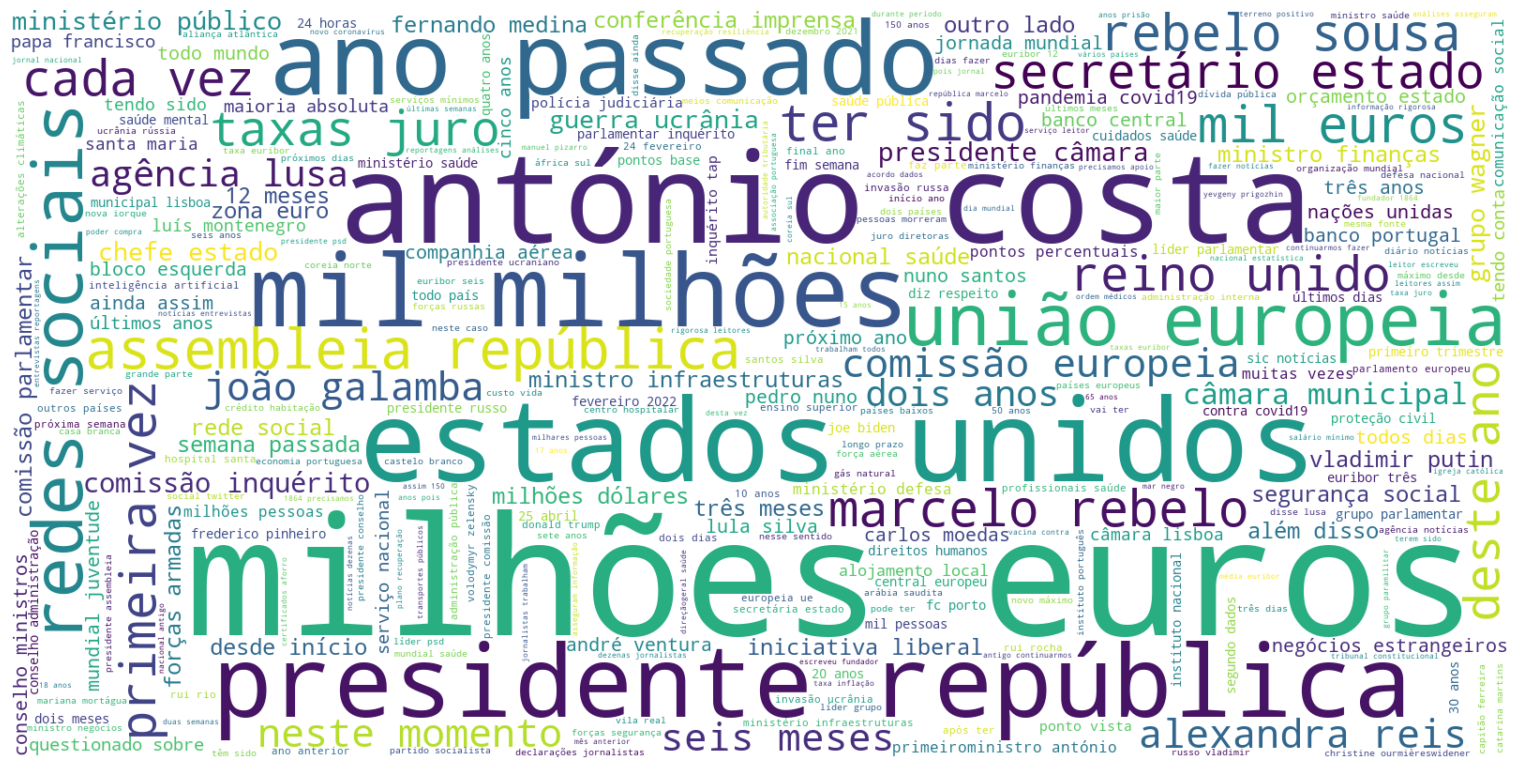

In [46]:
from nltk.util import ngrams

# Sample dataset (replace with your actual data)
fake_text = ' '.join(df.loc[df['Label'] == 1]['Text'])  # Concatenate fake texts

# Tokenize the text into words
words = nltk.word_tokenize(fake_text)

# Create bi-grams from the words
bi_grams = list(ngrams(words, 2))  # Change '2' to the desired n-gram size

# Convert bi-grams back to strings
bi_gram_strings = [' '.join(gram) for gram in bi_grams]

# Calculate bi-gram frequencies
bi_gram_frequencies = collections.Counter(bi_gram_strings)

# Generate the word cloud using the most common bi-grams
wordcloud = WordCloud(width=1600, height=800, background_color='white', max_words=300).generate_from_frequencies(bi_gram_frequencies)

# Plot the word cloud
print("300 most common bi-grams in Portuguese real news")
plt.figure(figsize=(15, 9))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off axis numbers and labels
plt.tight_layout(pad=0)
plt.show()

In [48]:
df = pd.read_csv("Final_preprocessed_dataset_portuguese.csv")

In [49]:
df.head()

Text           Source  \
0  PJ em operação internacional de tráfico de dro...               DN   
1  O texto foi criado - numa universidade da Repú...              NaN   
2  Nunca pague multas por conduzir sem carta ou s...  Contas Poupança   
3  Depois de António Guterres, uma estátua de D. ...    redes sociais   
4  O MAR, uma droga gratuita que cura pelo menos ...           Coruja   

                                                 URL  Label  \
0  https://www.dn.pt/sociedade/pj-em-operacao-int...      1   
1  https://poligrafo.sapo.pt/fact-check/fact-chec...      1   
2  https://arquivo.pt/wayback/20200626170105mp_/h...      0   
3  https://poligrafo.sapo.pt/fact-check/fact-chec...      0   
4  https://arquivo.pt/wayback/20181012145922mp_/h...      0   

                                   text_preprocessed  count_words_text  \
0  PJ operação internacional tráfico droga apreen...               206   
1  texto criar - universidade República Checa - s...               130   
2  nunca paguar multa conduzir carta Cartão Cidad...               306   
3  António Guterres , estátua D. Afonso Henriques...               164   
4  MAR , droga gratuito cura menos 16 DOENÇAS ! F...               538   

   num_nouns_text  num_verbs_text  num_adj_text  num_adv_text  \
0              42              28            15             5   
1              40              22            13             1   
2              81              69            32            19   
3              29              21            11             3   
4             191              66           105            24   

   sentiment_avg_text                                           features  
0             -0.7351  PJ operação internacional tráfico droga apreen...  
1              0.0000  texto criar - universidade República Checa - s...  
2              0.1677  nunca paguar multa conduzir carta Cartão Cidad...  
3              0.0000  António Guterres , estátua D. Afonso Henriques...  
4              0.5093  MAR , droga gratuito cura menos 16 DOENÇAS ! F...

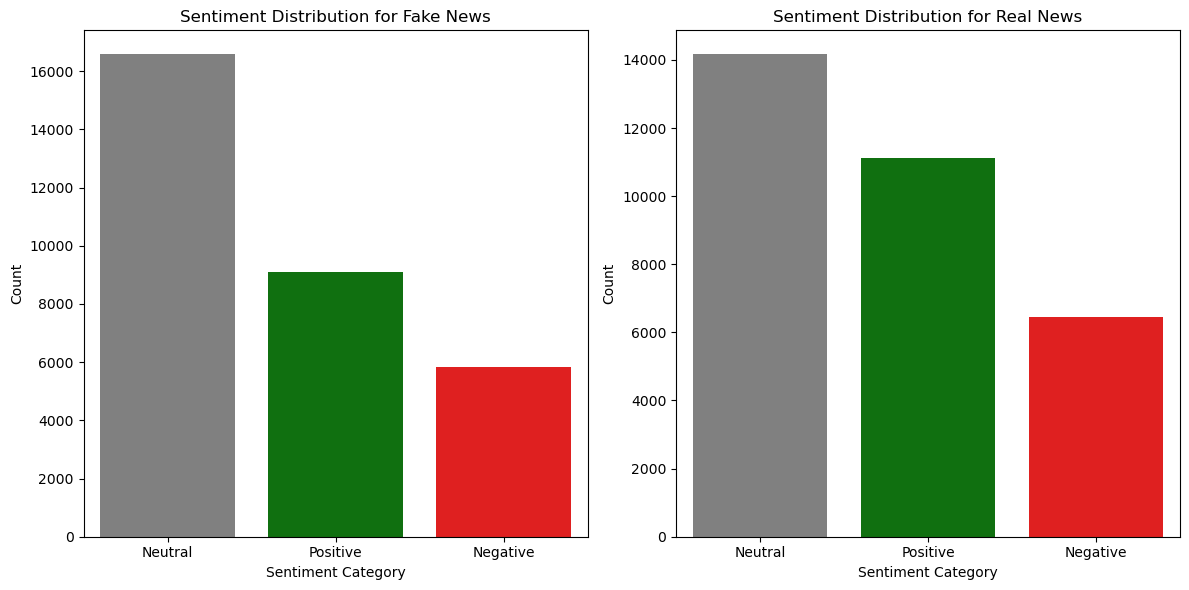

In [53]:
# Define sentiment thresholds
negative_threshold = -0.05
positive_threshold = 0.05

# Function to classify sentiments
def classify_sentiment(score):
    if score <= negative_threshold:
        return 'Negative'
    elif score >= positive_threshold:
        return 'Positive'
    else:
        return 'Neutral'

# Apply sentiment classification to each row
df['sentiment_category'] = df['sentiment_avg_text'].apply(classify_sentiment)

# Create separate DataFrames for real and fake news
real_news_df = df[df['Label'] == 1]
fake_news_df = df[df['Label'] == 0]

# Count the sentiment distribution for real news
real_sentiment_counts = real_news_df['sentiment_category'].value_counts()

# Count the sentiment distribution for fake news
fake_sentiment_counts = fake_news_df['sentiment_category'].value_counts()

# Define colors for the bars
colors = {'Negative': 'red', 'Neutral': 'gray', 'Positive': 'green'}

# Plot the sentiment distributions for real and fake news with custom colors
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.barplot(data=fake_sentiment_counts.reset_index(), x='index', y='sentiment_category', palette=colors)
plt.title('Sentiment Distribution for Fake News')
plt.xlabel('Sentiment Category')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
sns.barplot(data=real_sentiment_counts.reset_index(), x='index', y='sentiment_category', palette=colors)
plt.title('Sentiment Distribution for Real News')
plt.xlabel('Sentiment Category')
plt.ylabel('Count')

plt.tight_layout()
plt.show()